In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import geopandas
from dask.distributed import Client

In [4]:
client = Client()
client

2025-02-06 14:20:22,311 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-02-06 14:20:22,314 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-02-06 14:20:22,346 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/23420/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/23420/proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38925,Workers: 14
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/23420/proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40947,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0035.gadi.nci.org.au/23420/proxy/43387/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38983,


In [5]:
#Load test sydney RNS data (10 m u and v wind) for large and normal domain
path = "/g/data/ng72/ab4502/SY_1km_outputs/"

sy_u_l = xr.open_dataset(path+"BR2_1_L_CCI_WC_wind_u_10m.nc").chunk({"time":-1,"longitude":"auto","latitude":"auto"})
sy_v_l = xr.open_dataset(path+"BR2_1_L_CCI_WC_wind_v_10m.nc").chunk({"time":-1,"longitude":"auto","latitude":"auto"})
sy_u = xr.open_dataset(path+"BR2_1_CCI_WC_wind_u_10m.nc").chunk({"time":-1,"longitude":"auto","latitude":"auto"})
sy_v = xr.open_dataset(path+"BR2_1_CCI_WC_wind_v_10m.nc").chunk({"time":-1,"longitude":"auto","latitude":"auto"})

In [6]:
#Calculate mean U component for all times and for each hour of the day. Approximately onshore component of wind

u_l_mean = sy_u_l.mean("time").persist()
u_l_hourly = sy_u_l.groupby("time.hour").mean().persist()

u_mean = sy_u.mean("time").persist()
u_hourly = sy_u.groupby("time.hour").mean().persist()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


In [7]:
#Calculate wind speed and mean/variance of the wind speed

ws_l = np.sqrt(sy_u_l.x_wind**2 + sy_v_l.y_wind**2)
ws_l_mean = ws_l.mean("time").persist()
ws_l_hourly = ws_l.groupby("time.hour").mean().persist()
ws_l_var = ws_l.var("time").persist()

ws = np.sqrt(sy_u.x_wind**2 + sy_v.y_wind**2)
ws_mean = ws.mean("time").persist()
ws_hourly = ws.groupby("time.hour").mean().persist()
ws_var = ws.var("time").persist()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


Text(0.5, 1.0, 'Sydney-Large 1 km 10 m winds (2017-01-01 06:00)')

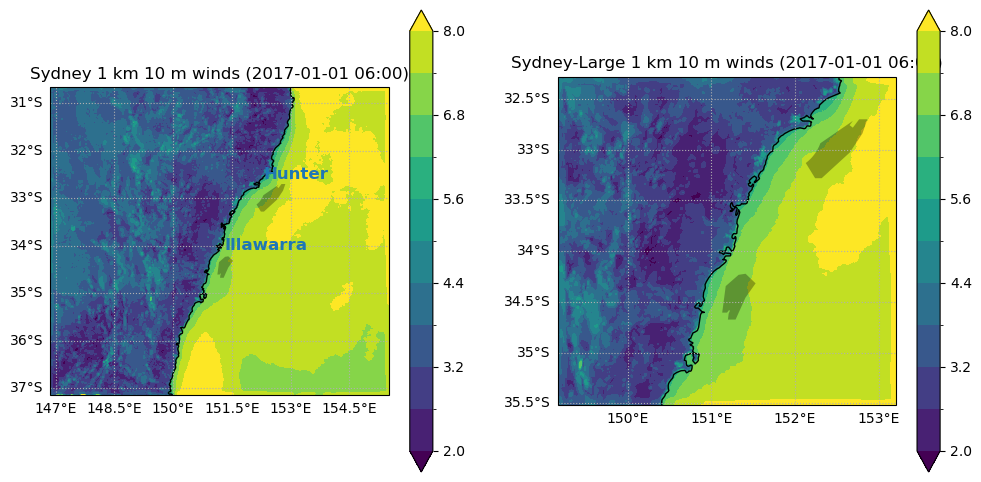

In [8]:
#Plot mean wind speed on offshore wind energy maps

plt.figure(figsize=[12,6])

t="2017-01-01 06:00"
step=20

offshore_regions = geopandas.read_file("/g/data/gb02/ab4502/coastline_data/Offshore_Renewable_Energy_Infrastructure_Regions/Offshore_Renewable_Energy_Infrastructure_Regions.shp")

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ws_l_mean.plot.contourf(levels=np.linspace(2,8,11))
geopandas.GeoDataFrame(offshore_regions).loc[[0],"geometry"].plot(ax=ax,alpha=0.3,color="k")
geopandas.GeoDataFrame(offshore_regions).loc[[8],"geometry"].plot(ax=ax,alpha=0.3,color="k")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":")
ax.text(152.3,-32.6,"Hunter",color="tab:blue",fontdict={"weight":"bold","size":12})
ax.text(151.3,-34.1,"Illawarra",color="tab:blue",fontdict={"weight":"bold","size":12})
ax.set_extent((u_l_hourly.longitude.min(),
               u_l_hourly.longitude.max(),
               u_l_hourly.latitude.min(),
               u_l_hourly.latitude.max()))

plt.title("Sydney 1 km 10 m winds (2017-01-01 06:00)")

step=40

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ws_mean.plot.contourf(levels=np.linspace(2,8,11))
geopandas.GeoDataFrame(offshore_regions).loc[[0],"geometry"].plot(ax=ax,alpha=0.3,color="k")
geopandas.GeoDataFrame(offshore_regions).loc[[8],"geometry"].plot(ax=ax,alpha=0.3,color="k")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":")

plt.title("Sydney-Large 1 km 10 m winds (2017-01-01 06:00)")

Text(0.5, 1.0, 'Sydney-Large 1 km 10 m winds (2017-01-01 06:00)')

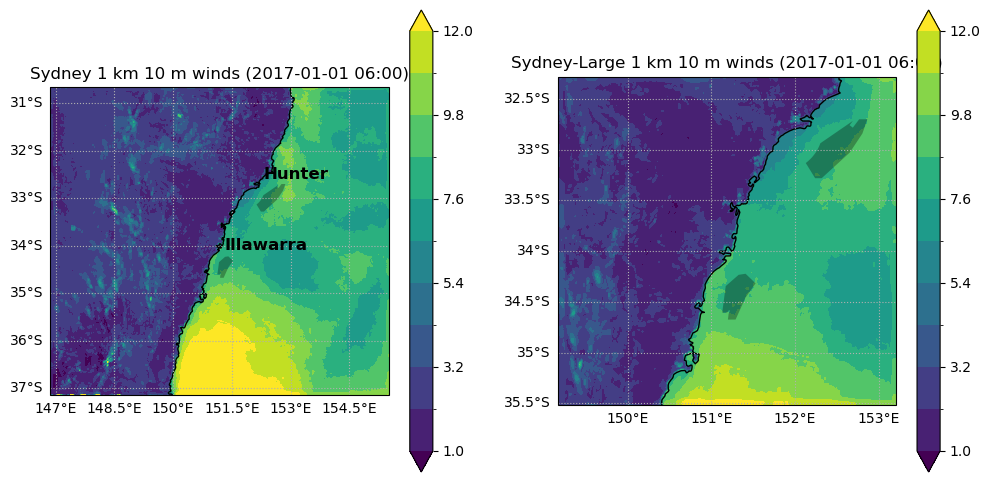

In [9]:
#Plot variance of the wind speed

plt.figure(figsize=[12,6])

t="2017-01-01 06:00"
step=20

offshore_regions = geopandas.read_file("/g/data/gb02/ab4502/coastline_data/Offshore_Renewable_Energy_Infrastructure_Regions/Offshore_Renewable_Energy_Infrastructure_Regions.shp")

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ws_l_var.plot.contourf(levels=np.linspace(1,12,11))
geopandas.GeoDataFrame(offshore_regions).loc[[0],"geometry"].plot(ax=ax,alpha=0.3,color="k")
geopandas.GeoDataFrame(offshore_regions).loc[[8],"geometry"].plot(ax=ax,alpha=0.3,color="k")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":")
ax.text(152.3,-32.6,"Hunter",color="k",fontdict={"weight":"bold","size":12})
ax.text(151.3,-34.1,"Illawarra",color="k",fontdict={"weight":"bold","size":12})
ax.set_extent((u_l_hourly.longitude.min(),
               u_l_hourly.longitude.max(),
               u_l_hourly.latitude.min(),
               u_l_hourly.latitude.max()))

plt.title("Sydney 1 km 10 m winds (2017-01-01 06:00)")

step=40

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
#wind_ds_l.sel(time=t).isel(latitude=slice(0,-1,step),longitude=slice(0,-1,step)).plot.quiver(x="longitude",y="latitude",u="u",v="v")
ws_var.plot.contourf(levels=np.linspace(1,12,11))
geopandas.GeoDataFrame(offshore_regions).loc[[0],"geometry"].plot(ax=ax,alpha=0.3,color="k")
geopandas.GeoDataFrame(offshore_regions).loc[[8],"geometry"].plot(ax=ax,alpha=0.3,color="k")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":")


plt.title("Sydney-Large 1 km 10 m winds (2017-01-01 06:00)")

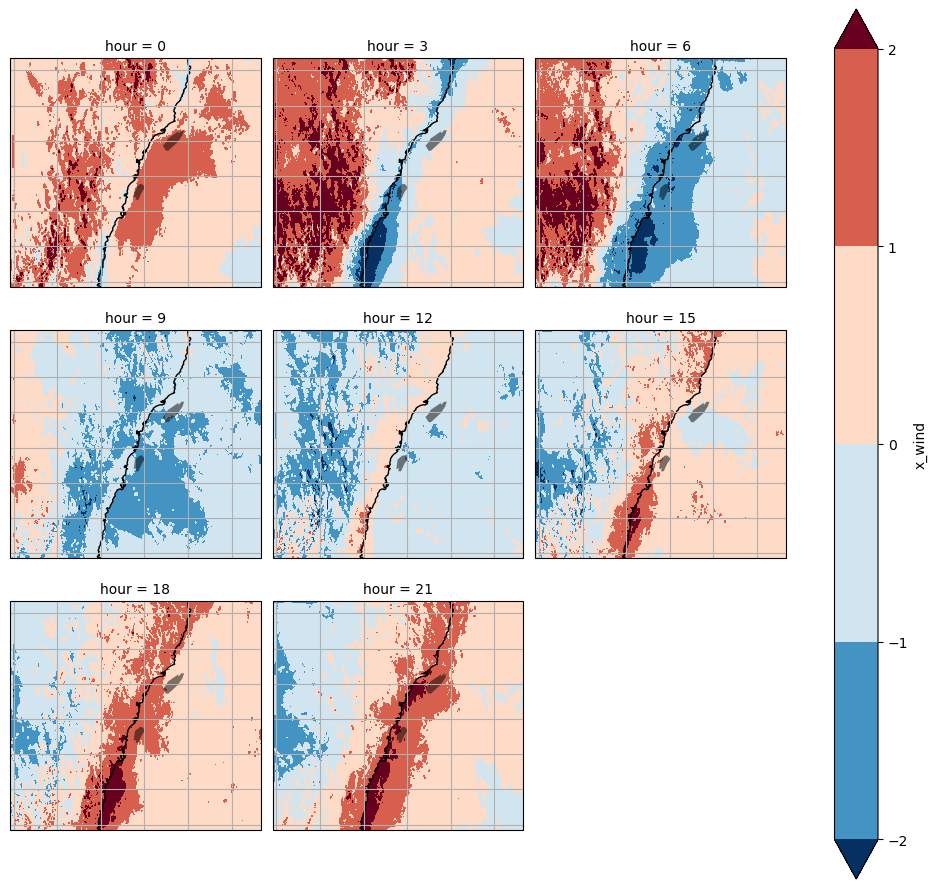

In [10]:
#Plot 3-hourly U wind anomalies for the large domain

fg = (u_l_hourly.x_wind.sel(hour=[0,3,6,9,12,15,18,21]) - u_l_mean.x_wind).plot.contourf(
    levels=[-2,-1,0,1,2],
    col="hour",
    col_wrap=3,
    robust=True,
    subplot_kws={"projection":ccrs.PlateCarree()}
)

for i in range(fg.axs.shape[0]):
    for j in range(fg.axs.shape[1]):
        ax=fg.axs[i,j]
        ax.coastlines()
        ax.gridlines()
        ax.set_extent((u_l_hourly.longitude.min(),
                       u_l_hourly.longitude.max(),
                       u_l_hourly.latitude.min(),
                       u_l_hourly.latitude.max()))
        geopandas.GeoDataFrame(offshore_regions).loc[[0],"geometry"].plot(ax=ax,alpha=0.5,color="k")
        geopandas.GeoDataFrame(offshore_regions).loc[[8],"geometry"].plot(ax=ax,alpha=0.5,color="k")



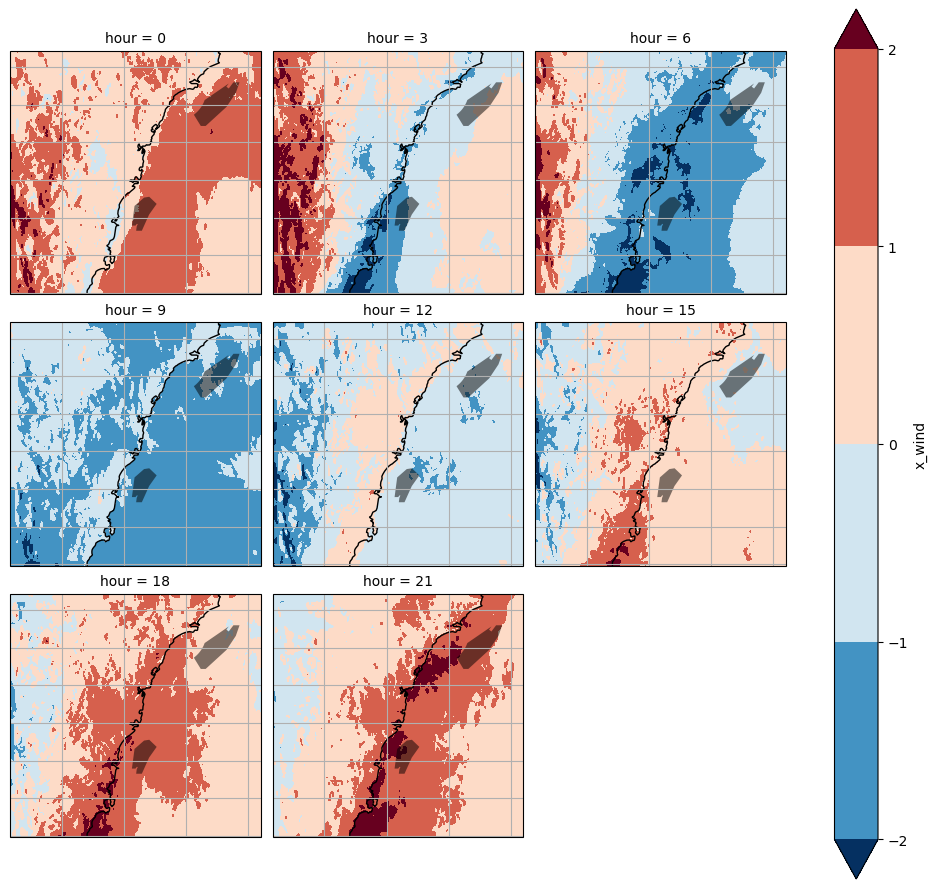

In [11]:
#Plot 3-hourly U wind anomalies for the normal domain

fg = (u_hourly.x_wind.sel(hour=[0,3,6,9,12,15,18,21]) - u_mean.x_wind).plot.contourf(
    levels=[-2,-1,0,1,2],
    col="hour",
    col_wrap=3,
    robust=True,
    subplot_kws={"projection":ccrs.PlateCarree()}
)

for i in range(fg.axs.shape[0]):
    for j in range(fg.axs.shape[1]):
        ax=fg.axs[i,j]
        ax.coastlines()
        ax.gridlines()
        ax.set_extent((u_hourly.longitude.min(),
                       u_hourly.longitude.max(),
                       u_hourly.latitude.min(),
                       u_hourly.latitude.max()))
        geopandas.GeoDataFrame(offshore_regions).loc[[0],"geometry"].plot(ax=ax,alpha=0.5,color="k")
        geopandas.GeoDataFrame(offshore_regions).loc[[8],"geometry"].plot(ax=ax,alpha=0.5,color="k")

